# ***Installing Libraries***

In [1]:
!pip install datasets --quiet

In [2]:
!pip install tokenizers --quiet

# ***Importing Libraries***

In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from collections import Counter
import random
import numpy as np
from PIL import Image
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers
import os
import numpy as np
import glob
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import math
import pandas as pd

# ***Datasets***

In [4]:
# Load both datasets
pcam = load_dataset("1aurent/PatchCamelyon")
# mhist = load_dataset("mamunrobi35/mhist_binary")

README.md:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

(…)-00000-of-00013-4717c3cf92578c96.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

(…)-00004-of-00013-f3cb3678324a5346.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)-00005-of-00013-959ba247c1881dc0.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)-00006-of-00013-318f5c6d89fc04ef.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

(…)-00007-of-00013-c8a1a9cf7273420c.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

(…)-00008-of-00013-3d4f66c19471ed0a.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

(…)-00009-of-00013-867b6df30133f28e.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

(…)-00010-of-00013-abf99d3df1f77818.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

(…)-00011-of-00013-e929006353f3ae95.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

(…)-00012-of-00013-73b855ce7d233beb.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

(…)-00000-of-00002-0e1a29e0620125c6.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

(…)-00001-of-00002-aad8011eb887c9d9.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

(…)-00000-of-00002-bb04e6313f58efa0.parquet:   0%|          | 0.00/376M [00:00<?, ?B/s]

(…)-00001-of-00002-3bfa172e8818685a.parquet:   0%|          | 0.00/375M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/262144 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/32768 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/32768 [00:00<?, ? examples/s]

In [5]:
# PCam
print("PatchCamelyon:")
print(pcam)
print("Columns:", pcam['train'].features)

PatchCamelyon:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 262144
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 32768
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 32768
    })
})
Columns: {'image': Image(mode=None, decode=True, id=None), 'label': Value(dtype='bool', id=None)}


In [6]:
# # MHIST
# print("MHIST Binary:")
# print(mhist)
# print("Columns:", mhist['train'].features)

# ***Samples + Class Distribution***

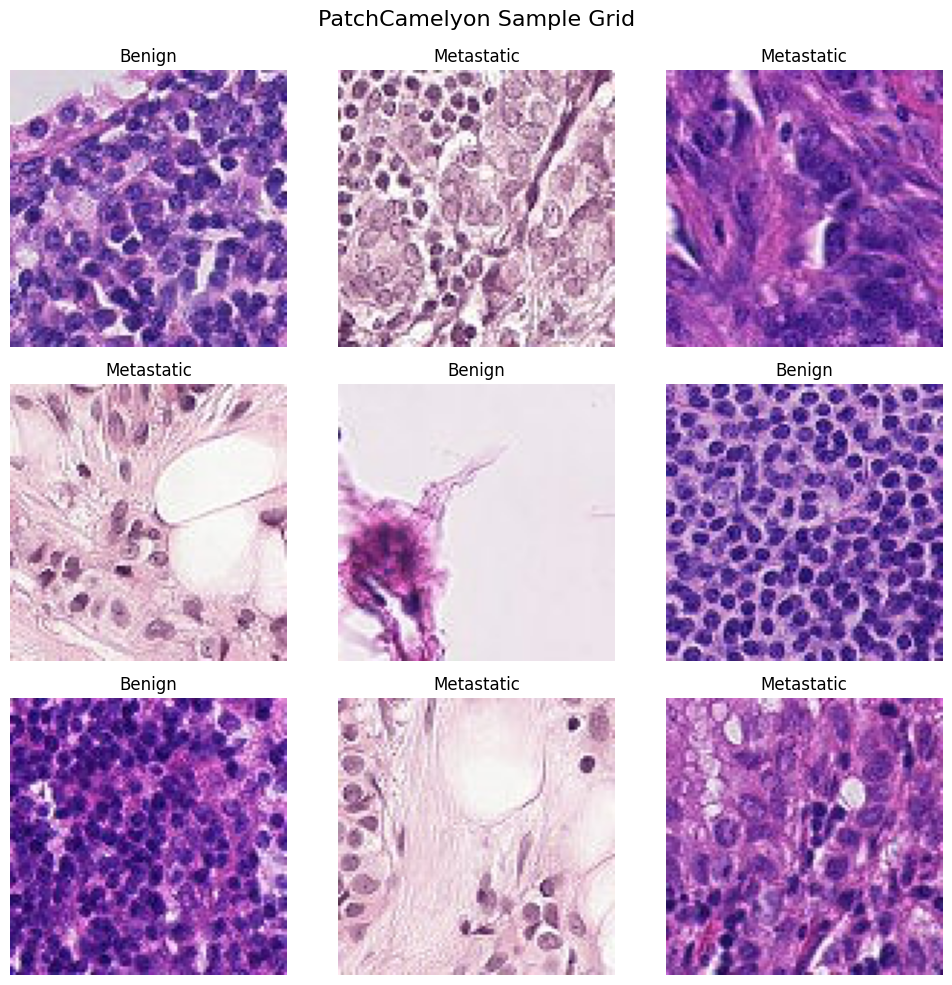

In [7]:
#Generating a 3x3 Grid for PCam Dataset Samples
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("PatchCamelyon Sample Grid", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = pcam['train'][i]['image']
    label = pcam['train'][i]['label']
    ax.imshow(img)
    ax.set_title('Metastatic' if label else 'Benign')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

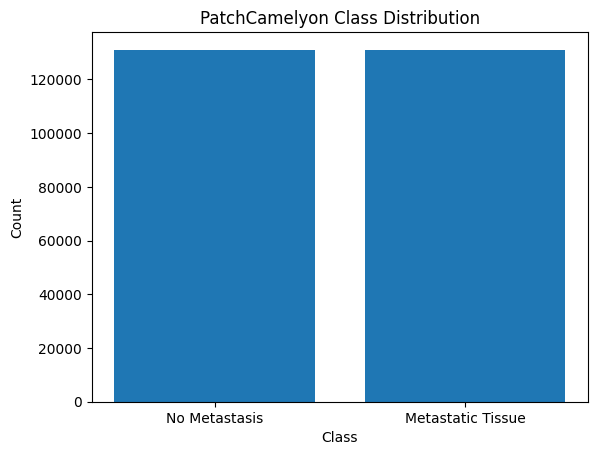

In [8]:
#Class distribution
labels = [x['label'] for x in pcam['train']]
counts = Counter(labels)
plt.bar(counts.keys(), counts.values())
plt.xticks([0, 1], ['No Metastasis', 'Metastatic Tissue'])
plt.title("PatchCamelyon Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [9]:
# #Generating a 3x3 Grid for MHist Binary Dataset samples
# random_indices = random.sample(range(len(mhist['train'])), 9)

# fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# fig.suptitle("MHIST Binary Sample Grid (Randomized)", fontsize=16)

# for i, ax in enumerate(axes.flat):
#     sample = mhist['train'][random_indices[i]]
#     img = sample['image']
#     label = sample['label']
#     ax.imshow(img)
#     ax.set_title('Hyperplastic' if label == 0 else 'Sessile Adenoma')
#     ax.axis('off')

# plt.tight_layout()
# plt.subplots_adjust(top=0.92)
# plt.show()

In [10]:
# #Class distribution
# labels = [x['label'] for x in mhist['train']]
# counts = Counter(labels)

# plt.bar(counts.keys(), counts.values())
# plt.xticks([0, 1], ['Hyperplastic', 'Sessile Adenoma'])
# plt.title("MHIST Class Distribution")
# plt.xlabel("Class")
# plt.ylabel("Count")
# plt.show()

# ***Data Processing***

## ***Image Transformation***

In [11]:
def preprocess_image(pil_img):
    """
    Resize a PIL image to 224x224 and normalize to [0, 1].
    Returns a float32 NumPy array of shape (224, 224, 3).
    """
    img_resized = pil_img.resize((224, 224))
    img_array = np.array(img_resized).astype(np.float32) / 255.0

    # Ensure image has 3 channels (some PIL images might be RGBA or grayscale)
    if img_array.ndim == 2:
        img_array = np.stack([img_array] * 3, axis=-1)
    elif img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]

    return img_array

In [12]:
# Test on MHIST or PCam
sample_img = pcam['train'][0]['image']
processed_img = preprocess_image(sample_img)

print("Processed Image Shape:", processed_img.shape)

Processed Image Shape: (224, 224, 3)


## ***Caption Generation***

In [13]:
def generate_pcam_caption(label: bool) -> str:
    return f"Histopathologic image of a lymph node {'with' if label else 'without'} metastatic tissue."

# def generate_mhist_caption(label: int) -> str:
#     return f"Colonic histology image showing a {'hyperplastic polyp' if label == 0 else 'sessile adenoma'}."

In [14]:
# PCam label test
print(generate_pcam_caption(True))   # metastatic
print(generate_pcam_caption(False))  # benign

# # MHIST label test
# print(generate_mhist_caption(0))     # hyperplastic
# print(generate_mhist_caption(1))     # sessile adenoma

Histopathologic image of a lymph node with metastatic tissue.
Histopathologic image of a lymph node without metastatic tissue.


In [15]:
# Collect captions from PCam (1k cap)
MAX_PCAM_SAMPLES = 1000

# Cap the PCam training set to 1k using `select`
pcam_train_subset = pcam['train'].select(range(MAX_PCAM_SAMPLES))

# Now safely generate captions
pcam_captions_train = [
    generate_pcam_caption(int(sample['label']))
    for sample in pcam_train_subset
]

pcam_captions_val = [
    generate_pcam_caption(int(sample['label']))
    for sample in pcam['valid']
]

# mhist_captions_train = [
#     generate_mhist_caption(int(sample['label']))
#     for sample in mhist['train']
# ]

# Combine all for tokenizer training
all_captions = pcam_captions_train + pcam_captions_val

## ***Tokenizer***

In [16]:
# Initialize empty BPE tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

# Set normalizer and pre-tokenizer
tokenizer.normalizer = normalizers.Sequence([normalizers.NFKC()])
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Trainer config
trainer = trainers.BpeTrainer(
    vocab_size=8000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

# Train it on the caption corpus
tokenizer.train_from_iterator(all_captions, trainer=trainer)

# Save to disk
tokenizer.save("bpe_tokenizer.json")
print("Tokenizer trained and saved to 'bpe_tokenizer.json'")

Tokenizer trained and saved to 'bpe_tokenizer.json'


## ***Preprocessing***

In [17]:
def save_npz_chunk(data, save_dir, split, chunk_id):
    os.makedirs(os.path.join(save_dir, split), exist_ok=True)
    path = os.path.join(save_dir, split, f"chunk_{chunk_id:03d}.npz")

    images = np.array([sample['image'] for sample in data])
    labels = np.array([sample['label'] for sample in data])
    input_ids = np.array([sample['input_ids'] for sample in data], dtype=object)
    attention_mask = np.array([sample['attention_mask'] for sample in data], dtype=object)

    np.savez_compressed(path, image=images, label=labels, input_ids=input_ids, attention_mask=attention_mask)

In [18]:
def stream_and_save(dataset, tokenizer, caption_fn, dataset_name, split, save_dir, max_samples=None, batch_size=100):
    data = dataset[split]
    if max_samples:
        data = data.select(range(max_samples))

    is_test = split == 'test'
    chunk = []
    chunk_id = 0

    for i, sample in enumerate(data):
        image_array = preprocess_image(sample['image'])
        label = int(sample['label'])

        if is_test:
            caption = {
                'pcam': "Histopathologic slide of a lymph node. Provide a diagnosis.",
                # 'mhist': "Colonic histology image. Provide a diagnosis."
            }[dataset_name]
        else:
            caption = caption_fn(label)

        enc = tokenizer.encode(caption)

        chunk.append({
            'image': image_array,
            'label': label,
            'input_ids': enc.ids,
            'attention_mask': enc.attention_mask
        })

        if len(chunk) == batch_size or i == len(data) - 1:
            save_npz_chunk(chunk, save_dir, split, chunk_id)
            chunk = []
            chunk_id += 1

In [19]:
tokenizer = Tokenizer.from_file("bpe_tokenizer.json")
SAVE_DIR = "preprocessed_data"

# PCam
stream_and_save(pcam, tokenizer, generate_pcam_caption, "pcam", "train", SAVE_DIR, max_samples=1000)
stream_and_save(pcam, tokenizer, generate_pcam_caption, "pcam", "valid", SAVE_DIR, max_samples=128)
stream_and_save(pcam, tokenizer, generate_pcam_caption, "pcam", "test", SAVE_DIR, max_samples=128)

# # MHIST
# stream_and_save(mhist, tokenizer, generate_mhist_caption, "mhist", "train", SAVE_DIR)

# ***Image Embeddings + PCA***

## ***PCam***

In [20]:
def load_npz_batches(path, max_samples=1000):
    """
    Load preprocessed .npz files and return arrays for analysis.
    Stops after collecting `max_samples`.
    """
    files = sorted(glob.glob(os.path.join(path, "*.npz")))

    images, labels = [], []

    for file in files:
        data = np.load(file, allow_pickle=True)
        images.append(data['image'])
        labels.append(data['label'])

        if sum(len(lbls) for lbls in labels) >= max_samples:
            break

    images = np.concatenate(images, axis=0)[:max_samples]
    labels = np.concatenate(labels, axis=0)[:max_samples]

    return images, labels

In [21]:
# Load MobileNetV2 as an image encoder
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg',
    weights='imagenet'
)

@tf.function
def extract_image_embeddings_tf(images):
    preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(images * 255.0)
    return mobilenet(preprocessed)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
# Load data (e.g., PCam train set)
images, labels = load_npz_batches("preprocessed_data/train", max_samples=1000)

def batch_extract_embeddings(images, batch_size=128):
    all_embeddings = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        batch_tensor = tf.convert_to_tensor(batch, dtype=tf.float32)
        batch_embed = extract_image_embeddings_tf(batch_tensor).numpy()
        all_embeddings.append(batch_embed)
    return np.concatenate(all_embeddings, axis=0)

# Run it safely
embeddings = batch_extract_embeddings(images, batch_size=128)

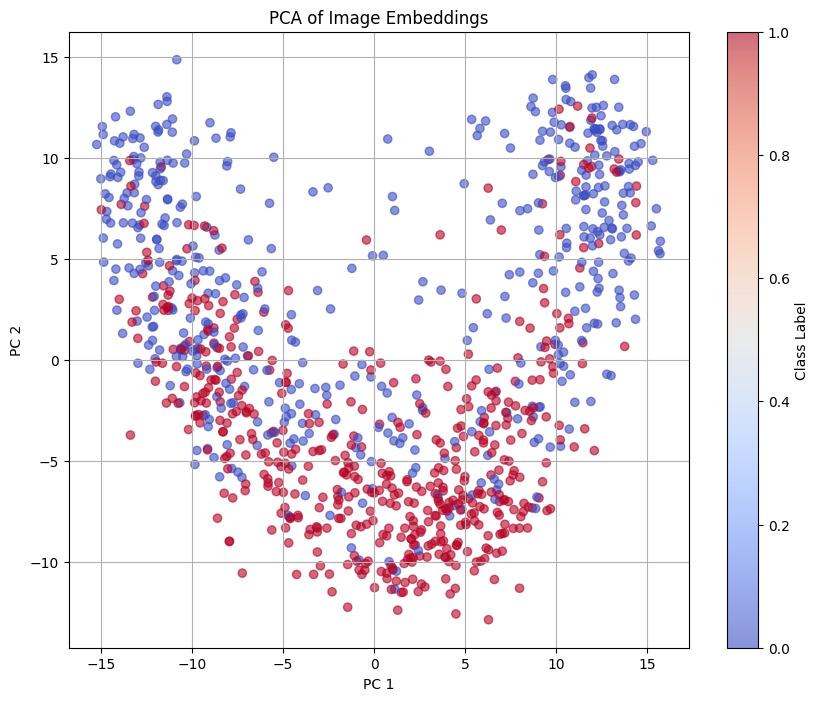

In [23]:
# Reduce to 2D with PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title("PCA of Image Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label="Class Label")
plt.grid(True)
plt.show()

## ***MHist***

In [24]:
# # Load MHIST (train or test split)
# mhist_images, mhist_labels = load_npz_batches("preprocessed_data/train", max_samples=3000)

# print("Loaded MHIST:", mhist_images.shape, "Labels:", mhist_labels.shape)

In [25]:
# # Convert to tensor and extract embeddings
# mhist_images_tf = tf.convert_to_tensor(mhist_images, dtype=tf.float32)
# mhist_embeddings = extract_image_embeddings_tf(mhist_images_tf).numpy()

In [26]:
# # Reduce to 2D
# pca = PCA(n_components=2)
# mhist_emb_2d = pca.fit_transform(mhist_embeddings)

# # Plot
# plt.figure(figsize=(10, 8))
# plt.scatter(mhist_emb_2d[:, 0], mhist_emb_2d[:, 1], c=mhist_labels, cmap='viridis', alpha=0.7)
# plt.title("PCA of MHIST Image Embeddings")
# plt.xlabel("PC 1")
# plt.ylabel("PC 2")
# plt.colorbar(label="Label (0=Hyperplastic, 1=Sessile Adenoma)")
# plt.grid(True)
# plt.show()

# ***Prompt Engineering***

In [27]:
# 1. Direct Prompt
def direct_prompt(label, dataset="pcam"):
    if dataset == "pcam":
        return f"Histopathologic image of a lymph node {'with' if label else 'without'} metastatic tissue."
    else:
        return f"Colonic histology image showing a {'hyperplastic polyp' if label == 0 else 'sessile serrated adenoma'}."

# 2. Instructional Prompt
def instructional_prompt(_label, dataset="pcam"):
    if dataset == "pcam":
        return "Please determine whether this histopathologic lymph node image contains metastatic tissue."
    else:
        return "Please classify this colonic histology image as either hyperplastic polyp or sessile adenoma."

# 3. Few-shot Prompt
def few_shot_prompt(_label, dataset="pcam"):
    if dataset == "pcam":
        return (
            "Example 1: Image shows a lymph node without metastatic tissue.\n"
            "Example 2: Image shows a lymph node with metastatic tissue.\n"
            "Now, classify the following image."
        )
    else:
        return (
            "Example 1: Colonic image shows a hyperplastic polyp.\n"
            "Example 2: Colonic image shows a sessile adenoma.\n"
            "What does the next image show?"
        )

# 4. Uncertainty Prompt
def uncertainty_prompt(_label, dataset="pcam"):
    if dataset == "pcam":
        return "This image may or may not contain metastatic tissue. Analyze and decide."
    else:
        return "This might be a hyperplastic polyp or a sessile adenoma. Interpret the image carefully."

In [28]:
def stream_dataset_tf(
    dataset,
    tokenizer,
    caption_fn,
    dataset_name="pcam",
    split="train",
    batch_size=1000,
    max_samples=1000
):
    split_data = dataset[split]

    if max_samples:
        split_data = split_data.select(range(max_samples))

    current_batch = []

    for i, sample in enumerate(split_data):
        image_array = preprocess_image(sample['image'])
        label = int(sample['label'])

        caption = caption_fn(label)
        encoding = tokenizer.encode(caption)

        current_batch.append({
            "image": image_array,
            "input_ids": encoding.ids,
            "attention_mask": encoding.attention_mask,
            "label": label
        })

        if len(current_batch) == batch_size or i == len(split_data) - 1:
            yield current_batch
            current_batch = []

In [29]:
prompt_styles = {
    "direct": direct_prompt,
    "instructional": instructional_prompt,
    "few_shot": few_shot_prompt,
    "uncertainty": uncertainty_prompt
}

for style_name, prompt_fn in prompt_styles.items():
    print(f"\nStreaming data using prompt style: {style_name}")

    for batch in stream_dataset_tf(
        dataset=pcam,
        tokenizer=tokenizer,
        caption_fn=lambda label: prompt_fn(label, dataset="pcam"),
        dataset_name="pcam",
        split="valid",
        max_samples=1000,
        batch_size=128
    ):
        # Now you have preprocessed batches for this prompt style
        # You can save, inspect, or feed into training
        pass


Streaming data using prompt style: direct

Streaming data using prompt style: instructional

Streaming data using prompt style: few_shot

Streaming data using prompt style: uncertainty


# ***Model***

In [30]:
class MultimodalClassifier(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim=128):
        super().__init__()

        # Image encoder: MobileNetV2 → (None, 1280)
        self.image_encoder = tf.keras.applications.MobileNetV2(
            input_shape=(224, 224, 3),
            include_top=False,
            pooling='avg',
            weights='imagenet'
        )
        self.image_encoder.trainable = False

        # Text encoder: Embedding + average pooling
        self.text_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            mask_zero=True
        )
        self.text_pool = tf.keras.layers.GlobalAveragePooling1D()

        # Classifier
        self.classifier = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(2, activation='softmax')
        ])

    def call(self, inputs):
        image = inputs["image"]
        input_ids = inputs["input_ids"]

        # Image features
        image_feat = self.image_encoder(image)

        # Text features
        text_embed = self.text_embedding(input_ids)
        text_feat = self.text_pool(text_embed)

        # Fusion
        combined = tf.concat([image_feat, text_feat], axis=1)
        return self.classifier(combined)

In [31]:
tokenizer = Tokenizer.from_file("bpe_tokenizer.json")
vocab_size = tokenizer.get_vocab_size()

model = MultimodalClassifier(vocab_size)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
def load_npz_to_dataset(path, batch_size=32):
    files = sorted(glob.glob(path + "/*.npz"))

    def gen():
        for file in files:
            data = np.load(file, allow_pickle=True)
            for i in range(len(data['label'])):
                yield (
                    data['image'][i],
                    data['input_ids'][i],
                    data['label'][i]
                )

    def tf_encode(image, input_ids, label):
        return {
            "image": tf.convert_to_tensor(image, dtype=tf.float32),
            "input_ids": tf.convert_to_tensor(input_ids, dtype=tf.int32)
        }, tf.convert_to_tensor(label, dtype=tf.int32)

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    ).map(tf_encode).padded_batch(batch_size)

    return ds

In [33]:
batch_size = 64
steps_per_epoch = math.ceil(MAX_PCAM_SAMPLES / batch_size)

val_sample_count = 128
validation_steps = math.ceil(val_sample_count / batch_size)

train_ds = load_npz_to_dataset("preprocessed_data/train", batch_size=batch_size).take(steps_per_epoch).repeat()
val_ds = load_npz_to_dataset("preprocessed_data/valid", batch_size=batch_size).take(validation_steps)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # or 'val_accuracy' if you prefer
    patience=2,             # wait 3 epochs before stopping
    restore_best_weights=True,
    verbose=1
)

class KeepAlive(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} done — Accuracy: {logs['accuracy']:.4f}")


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stop, KeepAlive()],
    verbose=1
)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5535 - loss: 0.7748 Epoch 1 done — Accuracy: 0.5800
16/16 ━━━━━━━━━━━━━━━━━━━━ 283s 17s/step - accuracy: 0.5551 - loss: 0.7707 - val_accuracy: 0.7266 - val_loss: 0.4543
Epoch 2/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7242 - loss: 0.5276 Epoch 2 done — Accuracy: 0.7370
16/16 ━━━━━━━━━━━━━━━━━━━━ 239s 16s/step - accuracy: 0.7249 - loss: 0.5263 - val_accuracy: 0.7969 - val_loss: 0.3990
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7942 - loss: 0.4351 Epoch 3 done — Accuracy: 0.7990
16/16 ━━━━━━━━━━━━━━━━━━━━ 242s 16s/step - accuracy: 0.7944 - loss: 0.4344 - val_accuracy: 0.8281 - val_loss: 0.3706
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8346 - loss: 0.3801 Epoch 4 done — Accuracy: 0.8390
16/16 ━━━━━━━━━━━━━━━━━━━━ 242s 16s/step - accuracy: 0.8348 - loss: 0.3798 - val_accuracy: 0.8516 - val_loss: 0.3482
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8475 - loss: 0.3480 Epoch 5 done — Accuracy: 0.8580
16/16 ━━━━━━━━━━━━━━━━━━━━ 243s 16s/step - accuracy: 0.8481 - loss: 0.3480 - val_accuracy: 0.8516 - val_loss: 0.3434
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.8551 - loss: 0.

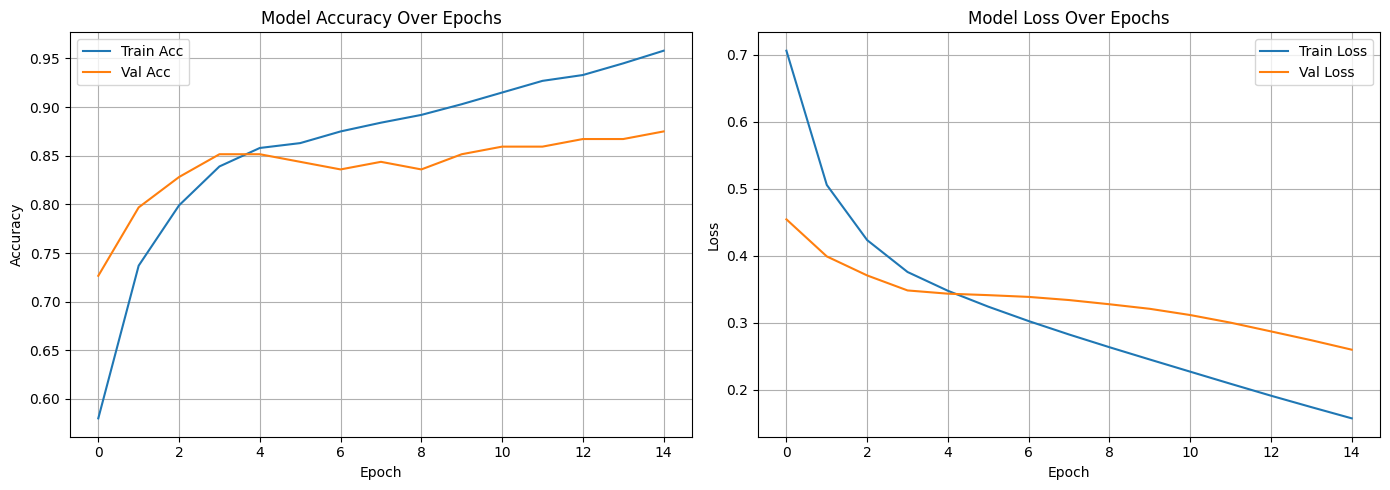

In [34]:
def plot_learning_curves(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Model Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Model Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call it
plot_learning_curves(history)

## ***Prompt Engineering Ablation***

In [35]:
def load_npz_prompt_dataset(path, tokenizer, prompt_fn, dataset_name="pcam", batch_size=64):
    files = sorted(glob.glob(path + "/*.npz"))

    def gen():
        for file in files:
            data = np.load(file, allow_pickle=True)
            for i in range(len(data['label'])):
                image = data['image'][i]
                label = int(data['label'][i])
                prompt = prompt_fn(label, dataset_name)
                encoding = tokenizer.encode(prompt)
                yield image, encoding.ids, label

    def tf_encode(image, input_ids, label):
        return {
            "image": tf.convert_to_tensor(image, dtype=tf.float32),
            "input_ids": tf.convert_to_tensor(input_ids, dtype=tf.int32)
        }, tf.convert_to_tensor(label, dtype=tf.int32)

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    ).map(tf_encode).padded_batch(batch_size)

    return ds


Evaluating with Direct Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Evaluating with Instructional Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Evaluating with Few-shot Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Evaluating with Uncertainty Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


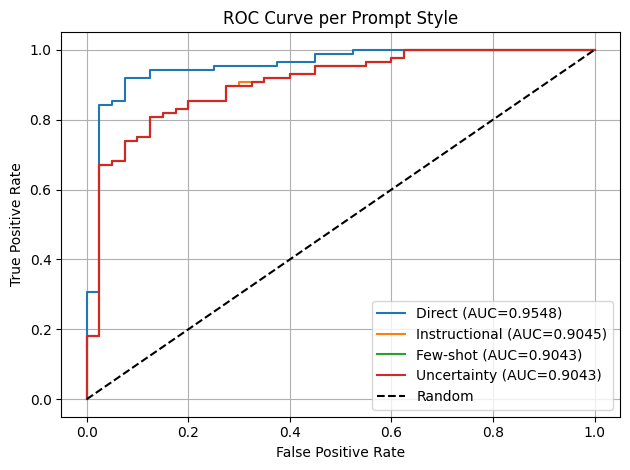

In [36]:
prompt_funcs = {
    "Direct": direct_prompt,
    "Instructional": instructional_prompt,
    "Few-shot": few_shot_prompt,
    "Uncertainty": uncertainty_prompt
}

results = {}

for name, fn in prompt_funcs.items():
    print(f"\nEvaluating with {name} Prompt")

    # Load test set with selected prompt function
    test_ds = load_npz_prompt_dataset(
        "preprocessed_data/test",
        tokenizer,
        prompt_fn=fn,
        dataset_name="pcam",  # change to "mhist" if needed
        batch_size=64
    )

    y_true = []
    y_probs = []

    for inputs, labels in test_ds:
        preds = model.predict(inputs)           # shape: (batch, 2)
        y_probs.extend(preds[:, 1])             # prob of class 1
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    y_pred = (y_probs > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_probs)

    results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc_score
    }

    # Plot ROC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.4f})")

# Final ROC Plot
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("ROC Curve per Prompt Style")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Metrics and Confusion Matrix — Direct Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


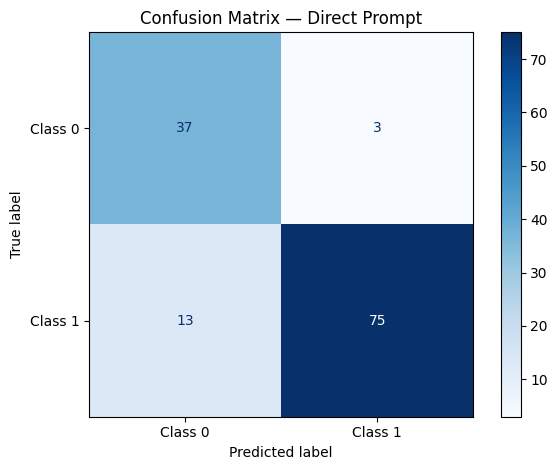


Metrics and Confusion Matrix — Instructional Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


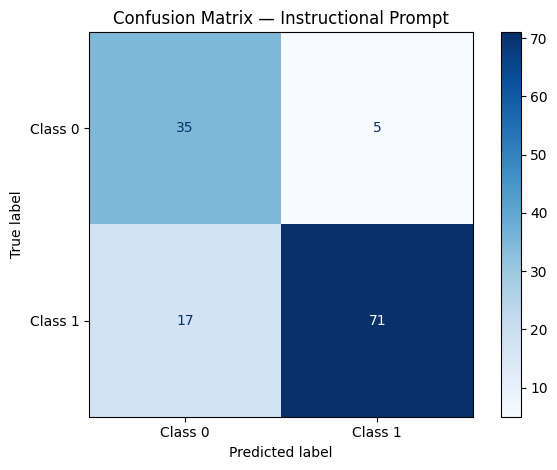


Metrics and Confusion Matrix — Few-shot Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


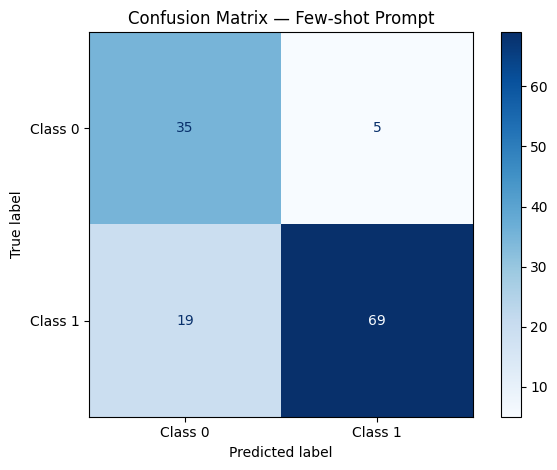


Metrics and Confusion Matrix — Uncertainty Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


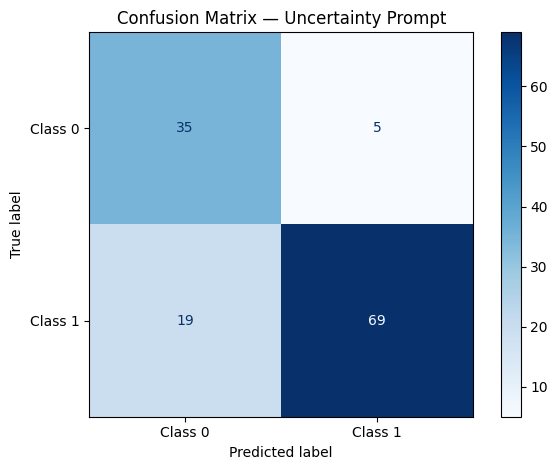

,accuracy,precision,recall,f1,auc
Direct,0.8750,0.9615,0.8523,0.9036,0.9548
Instructional,0.8281,0.9342,0.8068,0.8659,0.9045
Few-shot,0.8125,0.9324,0.7841,0.8519,0.9043
Uncertainty,0.8125,0.9324,0.7841,0.8519,0.9043


In [37]:
# Confusion Matrices per Prompt Style
for name in prompt_funcs.keys():
    print(f"\nMetrics and Confusion Matrix — {name} Prompt")

    y_true = []
    y_probs = []

    # Re-load test set for consistency
    test_ds = load_npz_prompt_dataset(
        "preprocessed_data/test",
        tokenizer,
        prompt_fn=prompt_funcs[name],
        dataset_name="pcam",
        batch_size=64
    )

    for inputs, labels in test_ds:
        preds = model.predict(inputs)
        y_probs.extend(preds[:, 1])
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    y_pred = (y_probs > 0.5).astype(int)

    # Redundant safeguard (if not yet in `results`)
    if name not in results:
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_probs)

        results[name] = {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "auc": auc_score
        }

    # Show Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix — {name} Prompt")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Final Metrics Table
df = pd.DataFrame(results).T
display(df.round(4))


Evaluating with Direct Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


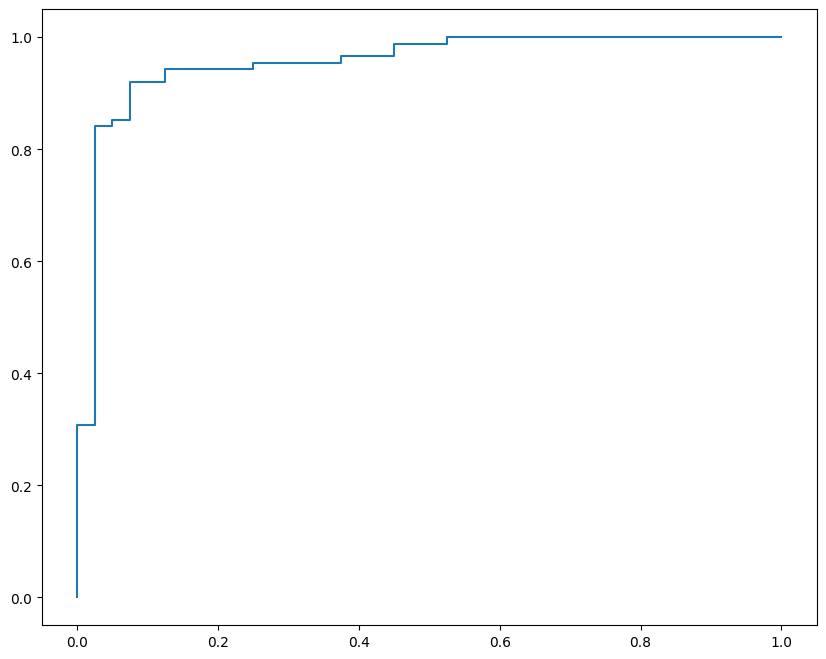

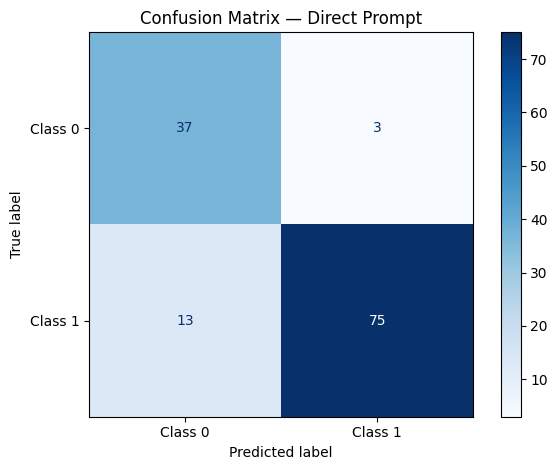


Evaluating with Instructional Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


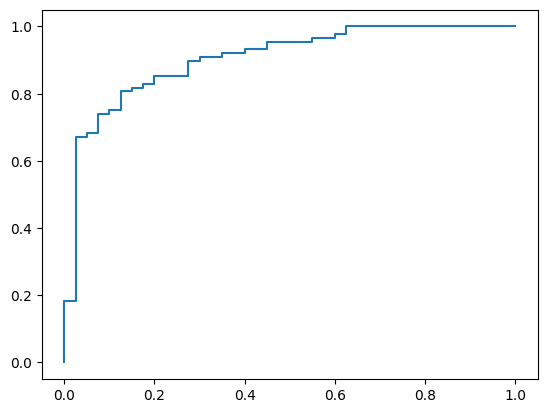

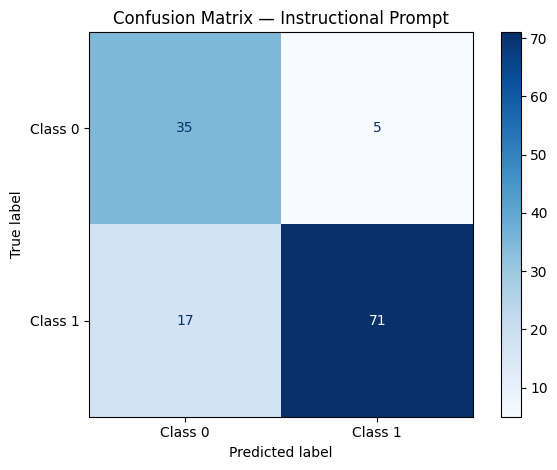


Evaluating with Few-shot Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


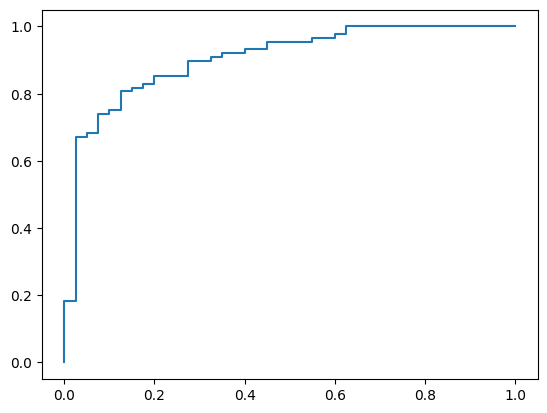

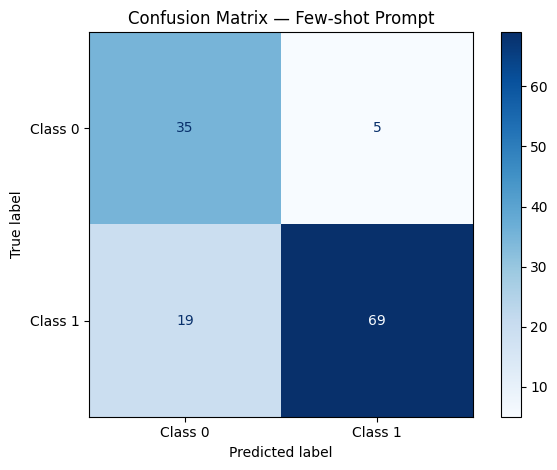


Evaluating with Uncertainty Prompt
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


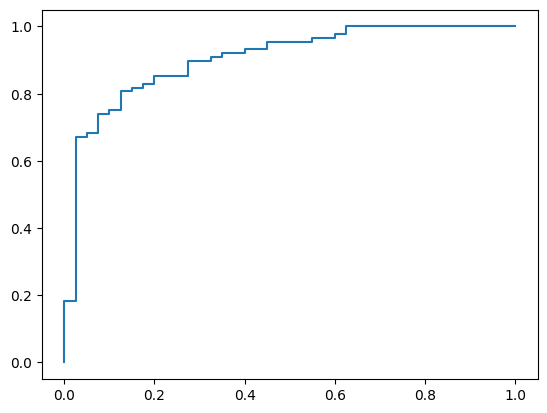

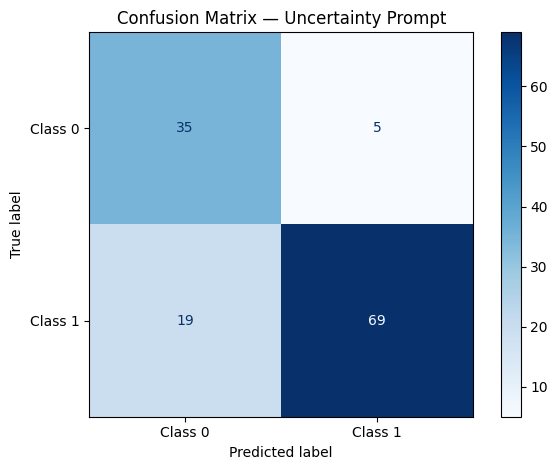

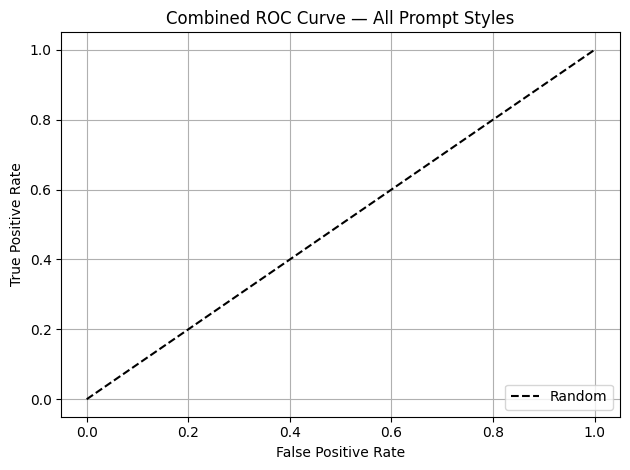

,accuracy,precision,recall,f1,auc
Direct,0.8750,0.9615,0.8523,0.9036,0.9548
Instructional,0.8281,0.9342,0.8068,0.8659,0.9045
Few-shot,0.8125,0.9324,0.7841,0.8519,0.9043
Uncertainty,0.8125,0.9324,0.7841,0.8519,0.9043


In [38]:
prompt_funcs = {
    "Direct": direct_prompt,
    "Instructional": instructional_prompt,
    "Few-shot": few_shot_prompt,
    "Uncertainty": uncertainty_prompt
}

results = {}

# One ROC plot for all prompts
plt.figure(figsize=(10, 8))

for name, fn in prompt_funcs.items():
    print(f"\nEvaluating with {name} Prompt")

    test_ds = load_npz_prompt_dataset(
        "preprocessed_data/test",
        tokenizer,
        prompt_fn=fn,
        dataset_name="pcam",
        batch_size=64
    )

    y_true, y_probs = [], []

    for inputs, labels in test_ds:
        preds = model.predict(inputs)
        y_probs.extend(preds[:, 1])  # Class 1 probability
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    y_pred = (y_probs > 0.5).astype(int)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_probs)

    results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc_score
    }

    # ROC Curve on shared plot
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.4f})")

    # Confusion Matrix per prompt
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix — {name} Prompt")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Final Combined ROC Curve Plot
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("Combined ROC Curve — All Prompt Styles")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Metrics Table
df = pd.DataFrame(results).T
display(df.round(4))